In [44]:
#start by importing relevant packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error

# Frame the Problem

## Clean the data 

In [2]:
#import the data and look at the info of the data set and preview the first five rows
df_test=pd.read_csv("test.csv")
df_train=pd.read_csv("train.csv")

print(df_train.shape)
display(df_train.info())
display(df_train.head())

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

None

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>],
       [<AxesSubplot:title={'center':'BsmtHalfBath'

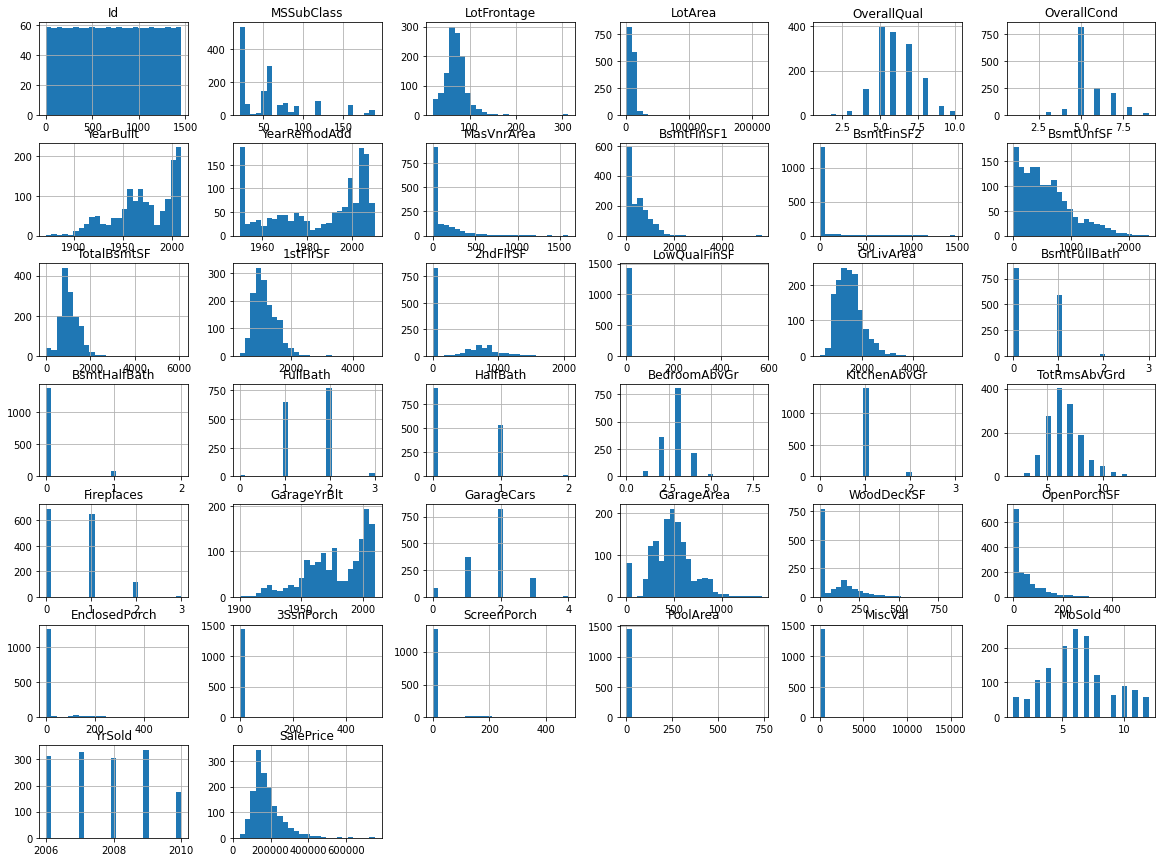

In [3]:
#quickly visualize the training data-histograms
df_train.hist(bins=25, figsize=(20,15))

Notice:

- YearBuilt and YearRemodAdd seem to be linearly-correlated (need we include both? come back to this)
- Is it necessary to keep both 1stFlrSF and GrLivArea?- no just keep GrLivArea
- Is it necessary to keep both BedroomAbvGr, KitchenAbvGr and TotRmsAbvGrd?- no just keep TotRmsAbvGrd
- " WoodDeckSF, OpenPorchSF, EnclosedPorchSF, 3SsnProch, adn ScreenPorch?- just keep the sum of the OpenPorchSF+EnclosedPorchSF
- PoolArea all seems to have 0 as the only entry, is this true for test set too? If so therefore non-informative therefore delete feature- investigate more, keep in data set for now

In [4]:
#consider a scatter matrix here to investigate possible correlation between features

Drop:

-Alley: only 91/1460 non-null entries, not enough information to interpolate accurately.

-MiscFeature: the value of the miscellaneous feature is what is important, not necessarily what the feature is; also isufficient non-null entries (54/1460)

-PoolQC: insufficient non-null entries (7/1460)

-PoolArea: insufficient positive instances (similar case to PoolQC)

-Fence: insufficient non-null entries (281/1460)

-Id: non-predictive

-1stFlrSF, 2ndFlrSF : keeping GrLivArea as it contains information stored in these two variables.

-LandContour- this and the attribute "LandSlope" contain similar information (keeping LandSlope as it is a better attribute for generalizing the information they hold)

-OverallQual- the information in this attribute is correlated with the attribute "OverallCond"- we therefore will only keep the general OveralCond which is informed by OverallQual.

-ExterQual- similar to the above attributes, this attribute informs another (ExterCond) and so we opt to drop this one and keep the other which is more general.

-GarageQual- this attribute seems to hold the same information as GarageCond, and as such is redudant- drop

-TotalBsmtSF- this contains information stored in BsmtFinSF1, BmstFinSF2, and BsmtUnfSF (see cells below for how we deal with these remaining attributes)

-SaleType- do not beleive that this attribute is informative

One-Hot Encode: 

-All categorical features

In [5]:
#drop the non-predictive or redudant features
toBeDropped=["Alley","MiscFeature", "Fence","PoolQC", "Id", "PoolArea", "1stFlrSF","2ndFlrSF", "BedroomAbvGr",'KitchenAbvGr', "WoodDeckSF","ScreenPorch", "3SsnPorch", "LandContour","OverallQual", "ExterQual","GarageQual", "TotalBsmtSF", "SaleType" ]

Interesting Features:

-Condition1, Condition2: these features describe whether or not the house is in close proximity to a miscellaneous feature such as a railroad; not all instances of this categorical variable are informative (whether or not the railroad is on the east/west side of the property, for example) therefore we want to change all instances of these attributes to be binary (0 if not close to one, 1 if close to one)

-Going to sum up attribute values from BsmtFinSF1 and BsmtFinSF2 (and keep BsmtUnfSF the way it is) and create a new attribute in their place called BsmtFinSF


In [6]:
#change Condition1 and Condition2 to binary 
for i in df_train["Condition1"]:
    if i=="Norm":
        df_train['Condition1'].replace(to_replace="Norm", value=0, inplace=True)
    else:
        df_train["Condition1"].replace(to_replace=['Artery', "Feedr",'RRNn',"RRAn","PosN","PosA","RRNe","RRAe"],value=1, inplace=True)
        
for i in df_train["Condition2"]:
    if i=="Norm":
        df_train['Condition2'].replace(to_replace="Norm", value=0, inplace=True)
    else:
        df_train["Condition2"].replace(to_replace=['Artery', "Feedr",'RRNn',"RRAn","PosN","PosA","RRNe","RRAe"],value=1, inplace=True)



In [7]:
display(df_train["Condition2"])


0       0
1       0
2       0
3       0
4       0
       ..
1455    0
1456    0
1457    0
1458    0
1459    0
Name: Condition2, Length: 1460, dtype: int64

In [8]:
# sum up values of BsmtFinSF1 and BsmtFinSF2 and store the sum for each instance in new attribute called BsmtFinSF
df_train["BsmtFinSF"]=df_train["BsmtFinSF1"]+df_train["BsmtFinSF2"]
#now drop the other two columsn after performing the transformation
df_train=df_train.drop(["BsmtFinSF1","BsmtFinSF2"], axis=1)
# display(df_train.head())

The features with null values:

MasVnrArea (8), BsmtQual (37), BsmtCond (37), BsmtExposure (38), BsmtFinType1 (37), BsmtFinType2 (38), Electrical (1), FireplaceQu (770), GarageType (91), GarageYrBuilt (91), GarageFinish (91), GarageQual (91), GarageCond (91)

-either delete the instances with null entries or replace with reasonable values
( numerical values can be interpolated using median statistic, is it reasonable to use the "top" entry for filling in null instances in null-data?)




In [9]:
#since MasVnrArea, GarageYrBlt are numerical, replace null values with an appropriate value

# MasVnrArea, GarageYrBlt null values should just be replaced with zeros (either there are no Masonry Veneers or there is no Garage)

# df_train["MasVnrArea"].fillna(value=df_train["MasVnrArea"].median(), inplace=True)
# df_train["GarageYrBlt"].fillna(value=df_train["GarageYrBlt"].median(), inplace=True)

df_train["MasVnrArea"].fillna(0, inplace=True)
df_train["GarageYrBlt"].fillna(0, inplace=True)

In [10]:
cat=df_train[["Electrical", 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond']].describe()
cat

,Electrical,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond
count,1459,1423,1423,1422,1423,1422,770,1379,1379,1379,1379
unique,5,4,4,4,6,6,5,6,3,5,5
top,SBrkr,TA,TA,No,Unf,Unf,Gd,Attchd,Unf,TA,TA
freq,1334,649,1311,953,430,1256,380,870,605,1311,1326


In [11]:
####THIS IS WHAT WE SHOULD DO:
# null instances are NOT missing values in this data set for categorical values
#instead of "Nan" in the entry, change to another string pandas will not recognize as "null"- "empty" perhaps

for feature in cat.columns:
    df_train[feature].fillna("empty", inplace=True) #filling each Nan entry with "empty" so pandas doesnt set to null (all data is valid for these sets)
df_train.info() # checking that it actually worked


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   int64  
 14  Condition2     1460 non-null   int64  
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
df_train=df_train.drop(toBeDropped, axis=1)
# df_train=pd.get_dummies(df_train,columns=toBeDummied, drop_first=True)



In [13]:
#dummy variables after dropping others 
#identify all the categorical features
toBeDummied=[]
for i in range(df_train.shape[1]):
    if df_train.iloc[:,i].dtype==object:
        toBeDummied.append(df_train.columns[i])

In [14]:
print(toBeDummied)

['MSZoning', 'Street', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'PavedDrive', 'SaleCondition']


In [15]:
print(df_train.shape)

(1460, 61)


In [16]:
#now dummy the appropriate variables
df_train=pd.get_dummies(df_train, columns=toBeDummied, drop_first=True)

In [17]:
print(df_train.shape)

(1460, 205)


In [18]:
# check out the data now that all features should be numerical
df_train.describe()

,MSSubClass,LotFrontage,LotArea,Condition1,Condition2,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,...,GarageCond_Po,GarageCond_TA,GarageCond_empty,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,0.136986,0.010274,5.575342,1971.267808,1984.865753,103.117123,567.240411,...,0.004795,0.908219,0.055479,0.020548,0.917808,0.002740,0.008219,0.013699,0.820548,0.085616
std,42.300571,24.284752,9981.264932,0.343951,0.100873,1.112799,30.202904,20.645407,180.731373,441.866955,...,0.069100,0.288815,0.228992,0.141914,0.274751,0.052289,0.090317,0.116277,0.383862,0.279893
min,20.000000,21.000000,1300.000000,0.000000,0.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,59.000000,7553.500000,0.000000,0.000000,5.000000,1954.000000,1967.000000,0.000000,223.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,69.000000,9478.500000,0.000000,0.000000,5.000000,1973.000000,1994.000000,0.000000,477.500000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,80.000000,11601.500000,0.000000,0.000000,6.000000,2000.000000,2004.000000,164.250000,808.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,313.000000,215245.000000,1.000000,1.000000,9.000000,2010.000000,2010.000000,1600.000000,2336.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#look into what is going wrong with the Nan values left over after this processing?
# X_train_z_scaled[0:10,:] # there are still a few Nan's left

#what is the corresponding column name? Let's check to see how best to address this
# display(df_train.head(10))

#this column is the lot frontage, i think that a NaN value could/should be replaced with the mean values?
#a nan value perhaps means that there is no lot associated with the property- an apartment for exampl??
#in this case we should set all of the Nan values to 0

df_train["LotFrontage"].fillna(0,inplace=True)

#now check it worked
display(df_train.head(10))

#-CHECK LATER

,MSSubClass,LotFrontage,LotArea,Condition1,Condition2,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,...,GarageCond_Po,GarageCond_TA,GarageCond_empty,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,0,0,5,2003,2003,196.0,150,...,0,1,0,0,1,0,0,0,1,0
1,20,80.0,9600,1,0,8,1976,1976,0.0,284,...,0,1,0,0,1,0,0,0,1,0
2,60,68.0,11250,0,0,5,2001,2002,162.0,434,...,0,1,0,0,1,0,0,0,1,0
3,70,60.0,9550,0,0,5,1915,1970,0.0,540,...,0,1,0,0,1,0,0,0,0,0
4,60,84.0,14260,0,0,5,2000,2000,350.0,490,...,0,1,0,0,1,0,0,0,1,0
5,50,85.0,14115,0,0,5,1993,1995,0.0,64,...,0,1,0,0,1,0,0,0,1,0
6,20,75.0,10084,0,0,5,2004,2005,186.0,317,...,0,1,0,0,1,0,0,0,1,0
7,60,0.0,10382,1,0,6,1973,1973,240.0,216,...,0,1,0,0,1,0,0,0,1,0
8,50,51.0,6120,1,0,5,1931,1950,0.0,952,...,0,1,0,0,1,0,0,0,0,0
9,190,50.0,7420,1,1,6,1939,1950,0.0,140,...,0,1,0,0,1,0,0,0,1,0


In [20]:
#now that data has been appropriately cleaned split the training set into the feature matrix and target variables
X_train=df_train.drop("SalePrice",axis=1)
y_train=df_train["SalePrice"]

## Z-scale the data to ensure no features dominate the predictions

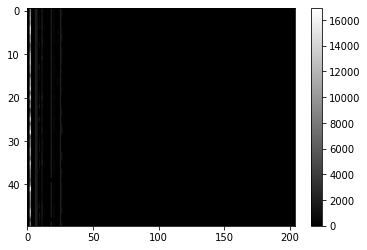

In [21]:
#visualize the first 50 houses as a color map to see the differences
first50=X_train.head(50)

plt.imshow(first50,cmap='gray', aspect='auto')
plt.colorbar()
plt.show()

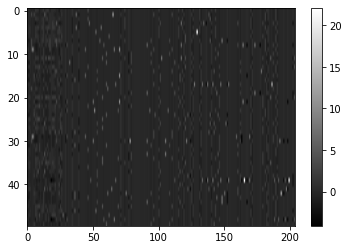

In [22]:
# we should standardize as many of the observations are encoded (0 or 1) and a few which were not are very large relatively speaking 
scaler=StandardScaler(with_mean=True, with_std=True)


#we only wish to scale the predictive features and not the target variable at this point (I think?)
X_train_z_scaled=scaler.fit_transform(X_train)

#now check out the values to see that it worked
first50=X_train_z_scaled[0:50,:]
plt.imshow(first50, cmap='gray', aspect="auto")
plt.colorbar()
plt.show()

In [23]:
#this is looking much better! Let us begin model selection and deployment

# Select and Train a Model

Start by defining a loss function: mean squared error

In [24]:
def mse(y,ypred):
    return np.mean((ypred-y)**2)


In [25]:
#lets split our training data into a training and validation set which we can use to train and validate our model
X_train, X_val, y_train, y_val= train_test_split(X_train_z_scaled, y_train, test_size=0.2, random_state=0)

#check it gave the right proportions
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1168, 204) (1168,) (292, 204) (292,)


## Bagging 


In [26]:
# in this algorithm, we tune the number of estimators to explore using the OOB score
#
# once the optimal number of estimators is determined, train and test the algorithm using this architecture

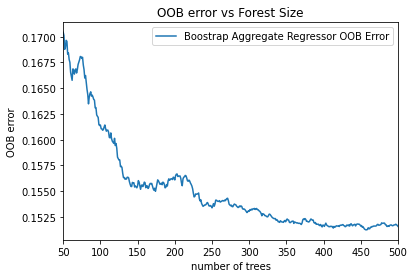

In [27]:
from sklearn.ensemble import BaggingRegressor

# BagReg=BaggingRegressor(oob_score=True, random_state=0)


# we are iterating over/ tuning the number of trees
from collections import OrderedDict

ensemble_clf=[('Boostrap Aggregate Regressor OOB Error', BaggingRegressor(oob_score=True, random_state=0))]

error_rate=OrderedDict((label,  []) for label, _ in ensemble_clf)

#specify the range of trees we wish to explore
min_trees=50
max_trees=500

##SOFIA- maybe try to train over up to 500 trees just to be sure the OOB score is truly level?

for label, clf in ensemble_clf:
    for i in range(min_trees, max_trees+1):
        clf.set_params(n_estimators=i) #set the number of trees for each forest
        clf.fit(X_train,y_train)
        
        #make sure to record the OOB score for each forest
        oob_error=1-clf.oob_score_
        error_rate[label].append((i,oob_error))
        
#now create a plot to visualize the OOB error as a function of the size of the forest
for label, clf_err in error_rate.items():
    xs, ys=zip(*clf_err)
    plt.plot(xs,ys, label=label)
    
plt.xlim(min_trees, max_trees)
plt.xlabel("number of trees")
plt.ylabel("OOB error")
plt.legend(loc='upper right')
plt.title("OOB error vs Forest Size")
plt.show()

In [28]:
#let us zoom in on the plot to see the true difference in scale of the OOB error
# #i am just interested in the region including number of trees>140

# #now create a plot to visualize the OOB error as a function of the size of the forest
# for label, clf_err in error_rate.items():
#     xs, ys=zip(*clf_err)
#     plt.plot(xs,ys, label=label)
    
# plt.xlim(140, max_trees)
# plt.xlabel("number of trees")
# plt.ylabel("OOB error")
# plt.legend(loc='upper right')
# plt.title("OOB error vs Forest Size")
# plt.show()

#### It looks as though the OOB error is beginning to really level off at around 250 estimators. Training of the algorithm should stop after the OOB error levels off, and so the optimal number of estimators used for this algorithm will be 250 if the OOB error does not change/level off significantly after this point.

In [45]:
#here we will re-train the bagging decision tree regressor using optimal n_estimators and calculate the training and validation error

bagReg=BaggingRegressor(oob_score=True, random_state=0, n_estimators=250).fit(X_train, y_train)
y_pred_train=bagReg.predict(X_train)
y_pred_val=bagReg.predict(X_val)

#now report the errors from each set of predictions as the mean squared error
mse_train=mse(y_train, y_pred_train)
mse_val=mse(y_val, y_pred_val)

print("training error using 240 estimators: ", mse_train)
print("validation error using 240 estimators: ", mse_val)

training error using 240 estimators:  127463830.21870998
validation error using 240 estimators:  1254852243.3294344


In [49]:
#reporting the Mean Absolute Percentage Error for the training and validation sets
MAPE_train=mean_absolute_percentage_error(y_train, y_pred_train)
MAPE_val=mean_absolute_percentage_error(y_val, y_pred_val)

print("The MAPE for the training set is: ", round(MAPE_train,4))
print("The MAPE for the validation set is: ", round(MAPE_val, 4))

The MAPE for the training set is:  0.04
The MAPE for the validation set is:  0.1045


## Random Forest

In [30]:
# in this algorithm, similarly to bagging regression, we tune the number of trees in the forest using the OOB score

# once the optimal number of estimators is determined, train and test the algorithm using this architecture


In [31]:
# # we are iterating over/ tuning the number of trees

# from sklearn.ensemble import RandomForestRegressor
# from collections import OrderedDict

# ensemble_clf=[('Random Forest Regressor OOB Error', RandomForestRegressor(oob_score=True, random_state=0))]

# error_rate=OrderedDict((label,  []) for label, _ in ensemble_clf)

# #specify the range of trees we wish to explore
# min_trees=5
# max_trees=10

# for label, clf in ensemble_clf:
#     for i in range(min_trees, max_trees+1):
#         clf.set_params(n_estimators=i) #set the number of trees for each forest
#         clf.fit(X_train_z_scaled,y_train)
        
#         #make sure to record the OOB score for each forest
#         oob_error=1-clf.oob_score_
#         error_rate[label].append((i,oob_error))
        
# #now create a plot to visualize the OOB error as a function of the size of the forest
# for label, clf_err in error_rate.items():
#     xs, ys=zip(*clf_err)
#     plt.plot(xs,ys, label=label)
    
# plt.plot(xlim(min_trees, max_trees))
# plt.xlabel("number of trees")
# plt.ylabel("OOB error")
# plt.legend(loc='upper right')
# plt.title("OOB error vs Forest Size")
# plt.show()


## XGBoosted Model

In [32]:
# this algorithm is much more sensitive to parameter changes, we will be tuning the learning rate, the tree depth, and the number of trees in the model

# to do this, we will perform a grid search and use cross validation to select the optimal model architecture (we create a validation set using a subset of the training data)


-We should explore small learning rates (larger learning rates do not allow the tree to extract information effectively as the number of branches increases)
-We want to keep the depth of the trees relatively short so that we can avoid too many strong learners in the model (this introduces variance).
-We do not know a priori how many trees will be optimal for the dataset as this depends on the complexity of the data and the size of the dataset

In [33]:
#define the XGB model
from xgboost import XGBRegressor
num_trees=[150,200,250,300,350,400,450]
depths=[1,2,3,4,5,6,7,8,9,10]
learn_rates=[1e-3,1e-2,0.1,0.5]
XGB_model=XGBRegressor(max_depth=depths, 
                       n_estimators=num_trees,
                       learning_rate=learn_rates, 
                       random_state=0)

#define the parameter grid
param_grid=dict({'n_estimators':num_trees,"max_depth":depths,'learning_rate':learn_rates})

In [34]:
###SOFIA- if training the grid search on the training data set takes too long, use a fraction of it instead

# #going to only train the grid search on a fraction of the training data to conserve resources
# val_train=X_train.copy()
# val_train["y"]=y_train.copy()
# val_train=val_train.sample(frac=0.5, random_state=0)

In [35]:
#train the grid search- going to use 3-fold cross-validation
#we can set refit=True if we wish- this means that it will re-fit the model at the end using the parameters with best cross-validation score
GridXGB=GridSearchCV(XGB_model, param_grid, cv=3, scoring='neg_root_mean_squared_error', refit=False)
GridXGB.fit(X_train, y_train) # train the grid search

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=[0.001, 0.01, 0.1, 0.5],
                                    max_delta_step=None,
                                    max_depth=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                    min_child_weight=None, missing=nan,
                                    monotone_constra...
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                             

In [39]:
# print(y_train.shape, X_train.shape)

(1168,) (1168, 204)


In [40]:
#now train the best model found from the grid search on all of the training parameters
#show the best parameters found
print(GridXGB.best_params_)

XGB_model_best=XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'), n_estimators=GridXGB.best_params_.get('n_estimators'), learning_rate=GridXGB.best_params_.get('learning_rate'), random_state=0)

XGB_model_best.fit(X_train, y_train)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
#now lets analyze the performance of the best model on both the training and validation sets'

y_pred_train=XGB_model_best.predict(X_train)
y_pred_val=XGB_model_best.predict(X_val)


#report the errors from each set of predictions as the mean squared error
mse_train=mse(y_train, y_pred_train)
mse_val=mse(y_val, y_pred_val)

print("training error using 240 estimators: ", mse_train)
print("validation error using 240 estimators: ", mse_val)


training error using 240 estimators:  52442907.84656837
validation error using 240 estimators:  1442857376.1948981


In [51]:
#reporting the Mean Absolute Percentage Error for the training and validation sets
MAPE_train=mean_absolute_percentage_error(y_train, y_pred_train)
MAPE_val=mean_absolute_percentage_error(y_val, y_pred_val)

print("The MAPE for the training set is: ", round(MAPE_train,4))
print("The MAPE for the validation set is: ", round(MAPE_val, 4))

The MAPE for the training set is:  0.0339
The MAPE for the validation set is:  0.1004
